# Baby N-Neuron Multi-Timescale RNN

**Goal**: Investigate how different timescales (α) affect a teacher-student learning setup.

We implement a minimal N-neuron RNN with the update rule:
$$r^j_{t+1} = (1 - \alpha^j) r^j_t + \alpha^j \phi(W_{rec} r_t + b)^j$$

where:
- $r \in \mathbb{R}^N$ is the hidden state
- $\alpha \in (0,1)^N$ are per-neuron timescale parameters
- $W_{rec} \in \mathbb{R}^{N \times N}$ is the recurrent weight matrix
- $b \in \mathbb{R}^N$ is the bias vector
- $\phi$ is Tanh or ReLU

**Experiment**: Train a student network (with different α than teacher) to match teacher trajectories by only learning $W_{rec}$ and $b$.

**Visualization**: 2D phase portraits for N=2, 3D phase portraits for N=3.

## 1. Setup and Imports

In [36]:
from typing import Callable
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [37]:
class BabyRNN(nn.Module):
    """
    Minimal N-neuron multi-timescale RNN (no external input).
    
    Update rule: r_{t+1} = (1 - α) * r_t + α * φ(W_rec @ r_t + b)
    """
    
    def __init__(
        self,
        num_neurons: int,
        alphas: torch.Tensor,
        activation: type[nn.Module] = nn.Tanh,
        zero_diag: bool = False,
    ) -> None:
        """
        Args:
            num_neurons: Number of neurons in the RNN.
            alphas: Per-neuron timescale parameters, shape (num_neurons,), values in (0, 1).
            activation: Activation function class (nn.Tanh or nn.ReLU).
            zero_diag: If True, freeze diagonal of W_rec to 0.
        """
        super().__init__()
        
        # Store alphas as a buffer (frozen, not trained)
        self.register_buffer("alphas", alphas.clone())

        self.num_neurons = num_neurons
        
        # Recurrent weights: W_rec @ r + b
        self.W_rec = nn.Linear(num_neurons, num_neurons, bias=True)
        
        # Activation function
        self.activation = activation()
        
        # Optional: zero diagonal constraint
        self.zero_diag = zero_diag
        if zero_diag:
            self.W_rec.weight.data.fill_diagonal_(0)
            self.W_rec.weight.register_hook(lambda g: g.clone().fill_diagonal_(0))
    
    def forward(self, r: torch.Tensor) -> torch.Tensor:
        """
        One-step update: r_{t+1} = (1 - α) * r_t + α * φ(W_rec @ r_t + b)
        
        Args:
            r: Hidden state, shape (..., 2)
        Returns:
            New hidden state, shape (..., 2)
        """
        pre_activation = self.W_rec(r)
        activated = self.activation(pre_activation)
        return (1 - self.alphas) * r + self.alphas * activated
    
    def delta(self, r: torch.Tensor) -> torch.Tensor:
        """
        Compute δr = r_{t+1} - r_t = α * (-r + φ(W_rec @ r + b))
        
        Args:
            r: Hidden state, shape (..., 2)
        Returns:
            Change in state, shape (..., 2)
        """
        pre_activation = self.W_rec(r)
        activated = self.activation(pre_activation)
        return self.alphas * (-r + activated)
    
    def unroll(self, r0: torch.Tensor, T: int) -> torch.Tensor:
        """
        Unroll the RNN for T steps.
        
        Args:
            r0: Initial state, shape (batch, 2)
            T: Number of time steps
        Returns:
            Trajectory, shape (batch, T+1, 2) including initial state
        """
        batch_size = r0.shape[0]

        trajectory = torch.zeros(batch_size, T + 1, self.num_neurons, device=r0.device)
        trajectory[:, 0] = r0
        
        r = r0
        for t in range(T):
            r = self.forward(r)
            trajectory[:, t + 1] = r
        
        return trajectory
    
    def copy_weights_from(self, other: "BabyRNN") -> None:
        """Copy W_rec and bias from another BabyRNN (keeping own alphas)."""
        self.W_rec.weight.data.copy_(other.W_rec.weight.data)
        self.W_rec.bias.data.copy_(other.W_rec.bias.data)


# Quick test
test_alphas = torch.tensor([0.3, 0.7, 0.5])
NUM_NEURONS = len(test_alphas)
test_rnn = BabyRNN(NUM_NEURONS, test_alphas, activation=nn.Tanh)
test_r = torch.randn(4, NUM_NEURONS)
print(f"Input shape: {test_r.shape}")
print(f"Output shape: {test_rnn(test_r).shape}")
print(f"Delta shape: {test_rnn.delta(test_r).shape}")
print(f"Unroll shape: {test_rnn.unroll(test_r, T=10).shape}")
print(f"\nAlphas: {test_rnn.alphas}")
print(f"W_rec:\n{test_rnn.W_rec.weight.data}")
print(f"Bias: {test_rnn.W_rec.bias.data}")

Input shape: torch.Size([4, 3])
Output shape: torch.Size([4, 3])
Delta shape: torch.Size([4, 3])
Unroll shape: torch.Size([4, 11, 3])

Alphas: tensor([0.3000, 0.7000, 0.5000])
W_rec:
tensor([[ 0.4414,  0.4792, -0.1353],
        [ 0.5304, -0.1265,  0.1165],
        [-0.2811,  0.3391,  0.5090]])
Bias: tensor([-0.4236,  0.5018,  0.1081])


## 3. Phase Portrait Visualization


In [38]:
def plot_phase_portrait_2d(
    rnn: BabyRNN,
    ax: plt.Axes,
    xlim: tuple[float, float] = (-2, 2),
    ylim: tuple[float, float] = (-2, 2),
    n_grid: int = 25,
    normalize_arrows: bool = True,
    trajectories: list[torch.Tensor] | None = None,
    title: str = "Phase Portrait",
) -> None:
    """
    Plot the vector field δr for a 2-neuron BabyRNN on a 2D grid.
    
    Args:
        rnn: The BabyRNN model (must have num_neurons=2).
        ax: Matplotlib 2D axes.
        xlim: Range for r1.
        ylim: Range for r2.
        n_grid: Number of grid points per dimension.
        normalize_arrows: If True, normalize to unit vectors.
        trajectories: Optional list of trajectories to overlay.
        title: Plot title.
    """
    assert rnn.num_neurons == 2, "2D plot requires num_neurons=2"
    
    # Create grid
    r1 = np.linspace(xlim[0], xlim[1], n_grid)
    r2 = np.linspace(ylim[0], ylim[1], n_grid)
    R1, R2 = np.meshgrid(r1, r2)
    
    # Flatten and convert to tensor
    r_grid = torch.tensor(
        np.stack([R1.flatten(), R2.flatten()], axis=1),
        dtype=torch.float32
    )
    
    # Compute delta
    with torch.no_grad():
        delta = rnn.delta(r_grid).numpy()
    
    U = delta[:, 0].reshape(R1.shape)
    V = delta[:, 1].reshape(R1.shape)
    
    # Optionally normalize to unit vectors
    if normalize_arrows:
        speed = np.sqrt(U**2 + V**2)
        speed[speed == 0] = 1.0
        U = U / speed
        V = V / speed
    
    # Quiver plot
    ax.quiver(
        R1, R2, U, V,
        angles="xy",
        scale_units="xy",
        scale=3,
        width=0.003,
        headwidth=4,
        headlength=3,
        alpha=0.7,
    )
    
    # Overlay trajectories if provided
    if trajectories is not None:
        colors = plt.cm.viridis(np.linspace(0, 1, len(trajectories)))
        for traj, color in zip(trajectories, colors):
            traj_np = traj.numpy()
            ax.plot(traj_np[:, 0], traj_np[:, 1], "-", color=color, linewidth=1.5, alpha=0.8)
            ax.scatter(traj_np[0, 0], traj_np[0, 1], s=50, color=color, marker="o", zorder=5)
            ax.scatter(traj_np[-1, 0], traj_np[-1, 1], s=50, color=color, marker="x", zorder=5)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(r"$r_1$", fontsize=12)
    ax.set_ylabel(r"$r_2$", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_aspect("equal")
    ax.grid(True, alpha=0.3)


def plot_phase_portrait_3d(
    rnn: BabyRNN,
    ax: Axes3D,
    lim: tuple[float, float] = (-3, 3),
    n_grid: int = 8,
    normalize_arrows: bool = True,
    trajectories: list[torch.Tensor] | None = None,
    title: str = "3D Phase Portrait",
) -> None:
    """
    Plot the vector field δr for a 3-neuron BabyRNN in 3D.
    
    Args:
        rnn: The BabyRNN model (must have num_neurons=3).
        ax: Matplotlib 3D axes.
        lim: Range for all axes (r1, r2, r3).
        n_grid: Number of grid points per dimension (keep small for clarity).
        normalize_arrows: If True, normalize to unit vectors.
        trajectories: Optional list of trajectories to overlay.
        title: Plot title.
    """
    assert rnn.num_neurons == 3, "3D plot requires num_neurons=3"
    
    # Create 3D grid
    r1 = np.linspace(lim[0], lim[1], n_grid)
    r2 = np.linspace(lim[0], lim[1], n_grid)
    r3 = np.linspace(lim[0], lim[1], n_grid)
    R1, R2, R3 = np.meshgrid(r1, r2, r3, indexing='ij')
    
    # Flatten and convert to tensor
    r_grid = torch.tensor(
        np.stack([R1.flatten(), R2.flatten(), R3.flatten()], axis=1),
        dtype=torch.float32
    )
    
    # Compute delta
    with torch.no_grad():
        delta = rnn.delta(r_grid).numpy()
    
    U = delta[:, 0]
    V = delta[:, 1]
    W = delta[:, 2]
    
    # Optionally normalize to unit vectors
    if normalize_arrows:
        speed = np.sqrt(U**2 + V**2 + W**2)
        speed[speed == 0] = 1.0
        U = U / speed
        V = V / speed
        W = W / speed
    
    # 3D quiver plot
    ax.quiver(
        R1.flatten(), R2.flatten(), R3.flatten(),
        U, V, W,
        length=0.3,
        normalize=False,
        alpha=0.5,
        arrow_length_ratio=0.3,
    )
    
    # Overlay trajectories if provided
    if trajectories is not None:
        colors = plt.cm.viridis(np.linspace(0, 1, len(trajectories)))
        for traj, color in zip(trajectories, colors):
            traj_np = traj.numpy()
            ax.plot3D(traj_np[:, 0], traj_np[:, 1], traj_np[:, 2], 
                     "-", color=color, linewidth=2, alpha=0.9)
            ax.scatter3D(traj_np[0, 0], traj_np[0, 1], traj_np[0, 2], 
                        s=80, color=color, marker="o")
            ax.scatter3D(traj_np[-1, 0], traj_np[-1, 1], traj_np[-1, 2], 
                        s=80, color=color, marker="x")
    
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_zlim(lim)
    ax.set_xlabel(r"$r_1$", fontsize=12)
    ax.set_ylabel(r"$r_2$", fontsize=12)
    ax.set_zlabel(r"$r_3$", fontsize=12)
    ax.set_title(title, fontsize=14)


def plot_phase_portrait(
    rnn: BabyRNN,
    ax,
    trajectories: list[torch.Tensor] | None = None,
    title: str = "Phase Portrait",
    **kwargs,
) -> None:
    """
    Unified phase portrait function that dispatches to 2D or 3D based on num_neurons.
    """
    if rnn.num_neurons == 2:
        plot_phase_portrait_2d(rnn, ax, trajectories=trajectories, title=title, **kwargs)
    elif rnn.num_neurons == 3:
        plot_phase_portrait_3d(rnn, ax, trajectories=trajectories, title=title, **kwargs)
    else:
        raise ValueError(f"Phase portrait only supports 2 or 3 neurons, got {rnn.num_neurons}")

In [39]:
# Create a teacher network and visualize its phase portrait
torch.manual_seed(123)

# Teacher with random alphas
teacher_alphas = torch.rand(NUM_NEURONS) * 0.8 + 0.1  # Uniform in (0.1, 0.9)
teacher_tanh = BabyRNN(NUM_NEURONS, teacher_alphas, activation=nn.Tanh)
teacher_relu = BabyRNN(NUM_NEURONS, teacher_alphas, activation=nn.ReLU)

# Copy same weights to ReLU version for fair comparison
teacher_relu.W_rec.weight.data.copy_(teacher_tanh.W_rec.weight.data)
teacher_relu.W_rec.bias.data.copy_(teacher_tanh.W_rec.bias.data)

print(f"Teacher alphas: {teacher_alphas}")
print(f"Teacher W_rec:\n{teacher_tanh.W_rec.weight.data}")
print(f"Teacher bias: {teacher_tanh.W_rec.bias.data}")

Teacher alphas: tensor([0.3369, 0.5132, 0.3013])
Teacher W_rec:
tensor([[ 0.2177, -0.4919,  0.4232],
        [-0.4196, -0.4590, -0.3648],
        [ 0.2615, -0.2133,  0.2161]])
Teacher bias: tensor([-0.4900, -0.3503, -0.2120])


## 4. Teacher-Student Training


### Hand-Picked 2-Neuron Network

Manually set W and b to explore specific dynamics.

Custom 2-neuron network:
Alphas: [0.5 0.3]
W_rec:
[[-0.116     -3.5400002]
 [ 3.5400002 -0.116    ]]
Bias: [ 1.83 -2.2 ]


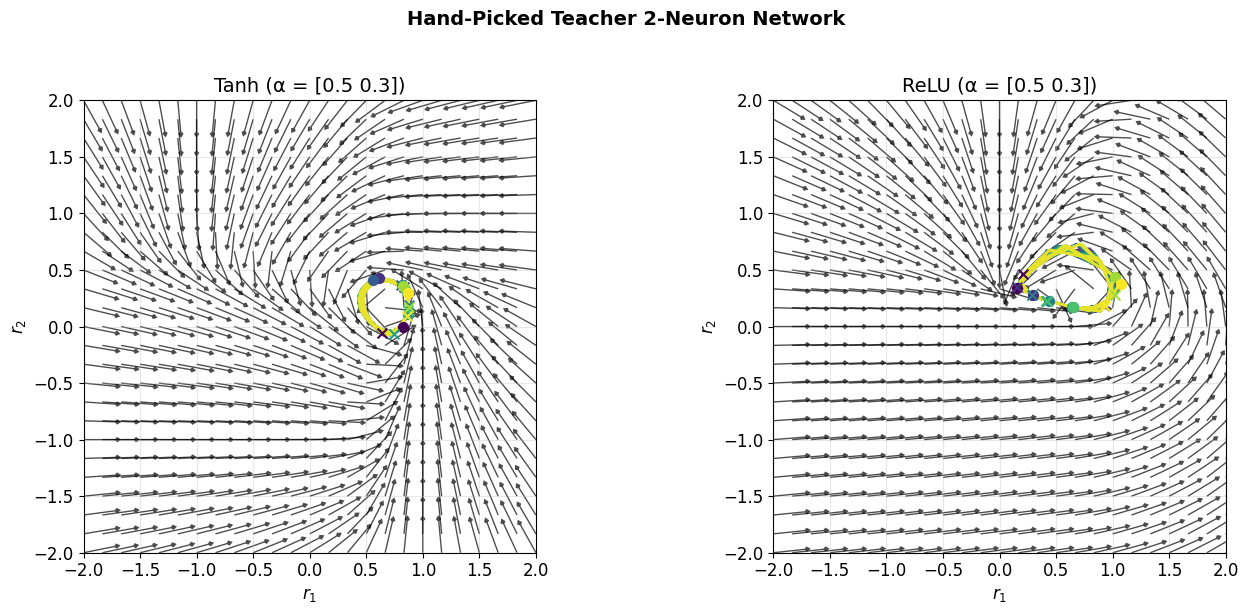

In [40]:
# === Hand-picked 2-neuron network ===

# Timescales (α ∈ (0, 1))
custom_alphas = torch.tensor([0.5, 0.3])

# # Recurrent weights W_rec (2x2 matrix)
# # W[i,j] = connection from neuron j to neuron i
# custom_W = 2*torch.tensor([
#     [0, -1],   # connections TO neuron 0
#     [1, 0],   # connections TO neuron 1
# ], dtype=torch.float32)

# # Bias
# #custom_b = torch.tensor([-1.0, -1.0], dtype=torch.float32)
# custom_b = torch.tensor([0.0, 0.0], dtype=torch.float32)


# Recurrent weights W_rec (2x2 matrix)
# (roughly: rotation + mild self-damping)
custom_W = 0.4*torch.tensor([
    [-0.29, -8.85],
    [ 8.85, -0.29],
], dtype=torch.float32)

# Bias (breaks symmetry + creates regime switching)
custom_b = torch.tensor([ 1.83, -2.20], dtype=torch.float32)


# Create networks with Tanh and ReLU
custom_tanh = BabyRNN(2, custom_alphas, activation=nn.Tanh)
custom_relu = BabyRNN(2, custom_alphas, activation=nn.ReLU)

# Set custom weights
custom_tanh.W_rec.weight.data = custom_W.clone()
custom_tanh.W_rec.bias.data = custom_b.clone()
custom_relu.W_rec.weight.data = custom_W.clone()
custom_relu.W_rec.bias.data = custom_b.clone()

print("Custom 2-neuron network:")
print(f"Alphas: {custom_alphas.numpy()}")
print(f"W_rec:\n{custom_W.numpy()}")
print(f"Bias: {custom_b.numpy()}")



# Generate trajectories from random initial conditions
torch.manual_seed(42)
n_traj = 8
r0_custom = torch.randn(n_traj, 2) * 0.7
T_custom = 100

lag = 20

with torch.no_grad():
    trajs_custom_tanh = [custom_tanh.unroll(r0_custom[i:i+1], T_custom).squeeze(0)[lag:] for i in range(n_traj)]
    trajs_custom_relu = [custom_relu.unroll(r0_custom[i:i+1], T_custom).squeeze(0)[lag:] for i in range(n_traj)]

# Plot 2D phase portraits
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

xlim = (-2,2)
ylim = (-2,2)

plot_phase_portrait_2d(
    custom_tanh, axes[0],
    xlim=xlim, ylim=ylim,
    trajectories=trajs_custom_tanh,
    title=f"Tanh (α = {custom_alphas.numpy()})"
)

plot_phase_portrait_2d(
    custom_relu, axes[1],
    xlim=xlim, ylim=ylim,
    trajectories=trajs_custom_relu,
    title=f"ReLU (α = {custom_alphas.numpy()})"
)

plt.suptitle("Hand-Picked Teacher 2-Neuron Network", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
def apply_alpha_preconditioning(student: BabyRNN, eps: float = 1e-8) -> None:
    """
    Scale W_rec gradients by 1/alpha to compensate for timescale differences.
    
    This preconditions the optimization by scaling gradients inversely with alpha,
    so neurons with small alpha (slow dynamics) get larger updates.
    
    Args:
        student: Student network with gradients computed.
        eps: Small constant for numerical stability.
    """
    alphas = student.alphas.detach()
    preconditioner = 1.0 / (alphas + eps)  # shape: (num_neurons,)
    
    # Scale W_rec weight gradients (row i scaled by preconditioner[i])
    if student.W_rec.weight.grad is not None:
        student.W_rec.weight.grad *= preconditioner.unsqueeze(1)
    
    # Scale W_rec bias gradients
    if student.W_rec.bias.grad is not None:
        student.W_rec.bias.grad *= preconditioner


def compute_vf_loss(
    teacher: BabyRNN,
    student: BabyRNN,
    r: torch.Tensor,
    normalize_mode: str = "none",
) -> torch.Tensor:
    """
    Compute vector field loss between teacher and student at given points.
    
    Args:
        teacher: Teacher network.
        student: Student network.
        r: State space points, shape (n_samples, num_neurons).
        normalize_mode: "none", "cosine", or "angular_mse".
    
    Returns:
        Scalar loss tensor.
    """
    eps = 1e-8
    
    with torch.no_grad():
        teacher_delta = teacher(r) - r
    student_delta = student(r) - r
    
    if normalize_mode == "none":
        return F.mse_loss(student_delta, teacher_delta)
    elif normalize_mode == "cosine":
        # Cosine similarity loss: 1 - cos(angle)
        cos_sim = F.cosine_similarity(student_delta, teacher_delta, dim=-1, eps=eps)
        return (1 - cos_sim).mean()
    elif normalize_mode == "angular_mse":
        # MSE on unit-normalized vectors
        teacher_norm = teacher_delta / (teacher_delta.norm(dim=-1, keepdim=True) + eps)
        student_norm = student_delta / (student_delta.norm(dim=-1, keepdim=True) + eps)
        return F.mse_loss(student_norm, teacher_norm)
    else:
        raise ValueError(f"Unknown normalize_mode: {normalize_mode}")


def compute_traj_loss(
    teacher: BabyRNN,
    student: BabyRNN,
    r0: torch.Tensor,
    T: int,
    lag: int = 0,
) -> torch.Tensor:
    """
    Compute trajectory loss between teacher and student from given initial conditions.
    
    Args:
        teacher: Teacher network.
        student: Student network.
        r0: Initial conditions, shape (batch, num_neurons).
        T: Trajectory length.
        lag: Burn-in timesteps to skip.
    
    Returns:
        Scalar loss tensor.
    """
    with torch.no_grad():
        teacher_traj = teacher.unroll(r0, T)
    student_traj = student.unroll(r0, T)
    return F.mse_loss(student_traj[:, lag:, :], teacher_traj[:, lag:, :])


def train_student(
    teacher: BabyRNN,
    student: BabyRNN,
    n_epochs: int = 500,
    batch_size: int = 64,
    T: int = 50,
    lr: float = 1e-2,
    init_scale: float = 2.0,
    lag: int = 0,
    vf_sample_scale: float = 3.0,
    vf_normalize_mode: str = "none",
    precondition: bool = False,
    verbose: bool = True,
) -> dict[str, list[float]]:
    """
    Train student to match teacher trajectories by learning W_rec and bias.
    Also tracks vector field loss for comparison.
    
    Args:
        teacher: Frozen teacher network.
        student: Student network (same architecture, different alphas).
        n_epochs: Number of training epochs.
        batch_size: Number of random initial conditions per batch.
        T: Trajectory length.
        lr: Learning rate.
        init_scale: Scale for random initial conditions.
        lag: Burn-in period — skip first `lag` timesteps when computing loss.
        vf_sample_scale: Scale for random state sampling when computing VF loss.
        vf_normalize_mode: Normalization mode for VF loss tracking ("none", "cosine", "angular_mse").
        precondition: If True, scale gradients by 1/alpha before optimizer step.
        verbose: Whether to print progress.
    
    Returns:
        Dictionary with "traj_loss" and "vf_loss" lists.
    """
    num_neurons = teacher.num_neurons
    optimizer = torch.optim.Adam(student.W_rec.parameters(), lr=lr)
    
    losses = {"traj_loss": [], "vf_loss": []}
    
    for epoch in range(n_epochs):
        # Random initial conditions for trajectory
        r0 = torch.randn(batch_size, num_neurons) * init_scale
        
        # Compute trajectory loss (used for optimization)
        traj_loss = compute_traj_loss(teacher, student, r0, T, lag)
        
        # Backprop on trajectory loss
        optimizer.zero_grad()
        traj_loss.backward()
        
        # Apply alpha preconditioning if requested
        if precondition:
            apply_alpha_preconditioning(student)
        
        optimizer.step()
        
        # Track trajectory loss
        losses["traj_loss"].append(traj_loss.item())
        
        # Also compute VF loss for monitoring (not used for optimization)
        with torch.no_grad():
            r_vf = torch.randn(batch_size * 4, num_neurons) * vf_sample_scale
            teacher_delta = teacher(r_vf) - r_vf
            student_delta = student(r_vf) - r_vf
            if vf_normalize_mode == "none":
                vf_loss = F.mse_loss(student_delta, teacher_delta)
            elif vf_normalize_mode == "cosine":
                cos_sim = F.cosine_similarity(student_delta, teacher_delta, dim=-1, eps=1e-8)
                vf_loss = (1 - cos_sim).mean()
            elif vf_normalize_mode == "angular_mse":
                eps = 1e-8
                teacher_norm = teacher_delta / (teacher_delta.norm(dim=-1, keepdim=True) + eps)
                student_norm = student_delta / (student_delta.norm(dim=-1, keepdim=True) + eps)
                vf_loss = F.mse_loss(student_norm, teacher_norm)
            losses["vf_loss"].append(vf_loss.item())
        
        if verbose and (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1:4d} | Traj Loss: {traj_loss.item():.6f} | VF Loss: {vf_loss.item():.6f}")
    
    return losses


def train_student_vectorfield(
    teacher: BabyRNN,
    student: BabyRNN,
    n_epochs: int = 500,
    n_samples: int = 256,
    sample_scale: float = 3.0,
    lr: float = 1e-2,
    normalize_mode: str = "none",
    traj_T: int = 50,
    traj_lag: int = 0,
    traj_init_scale: float = 2.0,
    precondition: bool = False,
    verbose: bool = True,
) -> dict[str, list[float]]:
    """
    Train student to match teacher's vector field directly.
    Also tracks trajectory loss for comparison.
    
    Args:
        teacher: Frozen teacher network.
        student: Student network (same architecture, different alphas).
        n_epochs: Number of training epochs.
        n_samples: Number of random state-space points per batch.
        sample_scale: Scale for random state sampling (std of Gaussian).
        lr: Learning rate.
        normalize_mode: "none" (MSE), "cosine" (1 - cos similarity), or "angular_mse" (MSE on unit vectors).
        traj_T: Trajectory length for computing trajectory loss.
        traj_lag: Burn-in for trajectory loss.
        traj_init_scale: Scale for trajectory initial conditions.
        precondition: If True, scale gradients by 1/alpha before optimizer step.
        verbose: Whether to print progress.
    
    Returns:
        Dictionary with "traj_loss" and "vf_loss" lists.
    """
    num_neurons = teacher.num_neurons
    optimizer = torch.optim.Adam(student.W_rec.parameters(), lr=lr)
    eps = 1e-8
    
    losses = {"traj_loss": [], "vf_loss": []}
    
    for epoch in range(n_epochs):
        # Sample random points in state space
        r = torch.randn(n_samples, num_neurons) * sample_scale
        
        # Compute vector fields
        with torch.no_grad():
            teacher_delta = teacher(r) - r
        student_delta = student(r) - r
        
        # Compute VF loss based on normalize_mode
        if normalize_mode == "none":
            vf_loss = F.mse_loss(student_delta, teacher_delta)
        elif normalize_mode == "cosine":
            cos_sim = F.cosine_similarity(student_delta, teacher_delta, dim=-1, eps=eps)
            vf_loss = (1 - cos_sim).mean()
        elif normalize_mode == "angular_mse":
            teacher_norm = teacher_delta / (teacher_delta.norm(dim=-1, keepdim=True) + eps)
            student_norm = student_delta / (student_delta.norm(dim=-1, keepdim=True) + eps)
            vf_loss = F.mse_loss(student_norm, teacher_norm)
        else:
            raise ValueError(f"Unknown normalize_mode: {normalize_mode}")
        
        # Backprop on VF loss
        optimizer.zero_grad()
        vf_loss.backward()
        
        # Apply alpha preconditioning if requested
        if precondition:
            apply_alpha_preconditioning(student)
        
        optimizer.step()
        
        # Track VF loss
        losses["vf_loss"].append(vf_loss.item())
        
        # Also compute trajectory loss for monitoring
        with torch.no_grad():
            batch_size = min(64, n_samples)
            r0 = torch.randn(batch_size, num_neurons) * traj_init_scale
            teacher_traj = teacher.unroll(r0, traj_T)
            student_traj = student.unroll(r0, traj_T)
            traj_loss = F.mse_loss(student_traj[:, traj_lag:, :], teacher_traj[:, traj_lag:, :])
            losses["traj_loss"].append(traj_loss.item())
        
        if verbose and (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1:4d} | VF Loss: {vf_loss.item():.6f} | Traj Loss: {traj_loss.item():.6f}")
    
    return losses

In [42]:
def create_teacher_student_pair(
    num_neurons: int,
    activation: type[nn.Module],
    teacher_seed: int = 42,
    student_alpha_seed: int = 123,
    zero_diag: bool = True,
    # Optional hand-picked values (override random init)
    custom_W: torch.Tensor | None = None,
    custom_b: torch.Tensor | None = None,
    custom_teacher_alphas: torch.Tensor | None = None,
    custom_student_alphas: torch.Tensor | None = None,
) -> tuple[BabyRNN, BabyRNN]:
    """
    Create a teacher-student pair with:
    - Same W_rec and bias initialization
    - Different alphas
    
    Args:
        num_neurons: Number of neurons in the RNN.
        activation: Activation function class.
        teacher_seed: Random seed for teacher initialization (ignored if custom values provided).
        student_alpha_seed: Random seed for student alpha initialization (ignored if custom provided).
        zero_diag: Whether to zero the diagonal of the recurrent weight matrix.
        custom_W: Optional hand-picked recurrent weight matrix, shape (num_neurons, num_neurons).
        custom_b: Optional hand-picked bias vector, shape (num_neurons,).
        custom_teacher_alphas: Optional hand-picked teacher alphas, shape (num_neurons,).
        custom_student_alphas: Optional hand-picked student alphas, shape (num_neurons,).
    
    Returns:
        (teacher, student) tuple.
    """

    zero_diag = True
    # Teacher alphas: custom or random
    if custom_teacher_alphas is not None:
        teacher_alphas = custom_teacher_alphas.clone()
    else:
        torch.manual_seed(teacher_seed)
        teacher_alphas = torch.rand(num_neurons) * 0.8 + 0.1  # (0.1, 0.9)
    
    teacher = BabyRNN(
        num_neurons, 
        teacher_alphas, 
        activation=activation,
        zero_diag=zero_diag,
        )
    
    # If custom W or b provided, override teacher's initialization
    if custom_W is not None:
        teacher.W_rec.weight.data = custom_W.clone()
    if custom_b is not None:
        teacher.W_rec.bias.data = custom_b.clone()
    
    # Student alphas: custom or random
    if custom_student_alphas is not None:
        student_alphas = custom_student_alphas.clone()
    else:
        torch.manual_seed(student_alpha_seed)
        student_alphas = torch.rand(num_neurons) * 0.8 + 0.1  # (0.1, 0.9)
    
    student = BabyRNN(
        num_neurons, 
        student_alphas, 
        activation=activation,
        zero_diag=zero_diag,
        )
    
    # Copy teacher's weights to student (so they start from same W_rec, b)
    student.copy_weights_from(teacher)
    
    return teacher, student


# Quick test (random init)
test_n = NUM_NEURONS
teacher_test, student_test = create_teacher_student_pair(test_n, nn.Tanh)
print(f"Teacher alphas: {teacher_test.alphas}")
print(f"Student alphas: {student_test.alphas}")
print(f"Weights match: {torch.allclose(teacher_test.W_rec.weight, student_test.W_rec.weight)}")

Teacher alphas: tensor([0.8058, 0.8320, 0.4063])
Student alphas: tensor([0.3369, 0.5132, 0.3013])
Weights match: True


In [43]:
def run_comparison_experiment(
    num_neurons: int,
    activation: type[nn.Module],
    custom_W: torch.Tensor,
    custom_b: torch.Tensor,
    custom_teacher_alphas: torch.Tensor,
    custom_student_alphas: torch.Tensor,
    n_epochs: int = 500,
    batch_size: int = 64,
    T: int = 60,
    lr: float = 1e-2,
    lag: int = 20,
    vf_normalize_mode: str = "none",
    zero_diag: bool = False,
    verbose: bool = True,
) -> dict:
    """
    Run a comparison experiment training the SAME initial student with both
    trajectory loss and vector field loss.
    
    Args:
        num_neurons: Number of neurons.
        activation: Activation function class (nn.Tanh or nn.ReLU).
        custom_W: Recurrent weight matrix.
        custom_b: Bias vector.
        custom_teacher_alphas: Teacher timescale parameters.
        custom_student_alphas: Student timescale parameters.
        n_epochs: Number of training epochs.
        batch_size: Batch size for training.
        T: Trajectory length.
        lr: Learning rate.
        lag: Burn-in period for trajectory loss.
        vf_normalize_mode: Normalization for VF loss ("none", "cosine", "angular_mse").
        zero_diag: Whether to zero diagonal of W_rec.
        verbose: Whether to print progress.
    
    Returns:
        Dictionary with:
            - "teacher": teacher network
            - "student_init": initial student network (for visualization)
            - "student_init_state": initial student state dict
            - "student_traj": student trained with trajectory loss
            - "student_vf": student trained with VF loss
            - "losses_traj": loss dict from trajectory training
            - "losses_vf": loss dict from VF training
            - "activation_name": name of activation function
    """
    # Create teacher
    teacher = BabyRNN(
        num_neurons,
        custom_teacher_alphas.clone(),
        activation=activation,
        zero_diag=zero_diag,
    )
    teacher.W_rec.weight.data = custom_W.clone()
    teacher.W_rec.bias.data = custom_b.clone()
    
    # Create initial student (will clone state for both trainings)
    student_init = BabyRNN(
        num_neurons,
        custom_student_alphas.clone(),
        activation=activation,
        zero_diag=zero_diag,
    )
    student_init.copy_weights_from(teacher)
    
    # Save initial state
    student_init_state = copy.deepcopy(student_init.state_dict())
    
    # Create student for trajectory training
    student_traj = BabyRNN(
        num_neurons,
        custom_student_alphas.clone(),
        activation=activation,
        zero_diag=zero_diag,
    )
    student_traj.load_state_dict(copy.deepcopy(student_init_state))
    
    # Create student for VF training
    student_vf = BabyRNN(
        num_neurons,
        custom_student_alphas.clone(),
        activation=activation,
        zero_diag=zero_diag,
    )
    student_vf.load_state_dict(copy.deepcopy(student_init_state))
    
    activation_name = activation.__name__
    
    # Train with trajectory loss
    if verbose:
        print("=" * 60)
        print(f"Training {activation_name} Student (Trajectory Loss)")
        print("=" * 60)
    
    losses_traj = train_student(
        teacher, student_traj,
        n_epochs=n_epochs,
        batch_size=batch_size,
        T=T,
        lr=lr,
        lag=lag,
        vf_sample_scale=3.0,
        vf_normalize_mode=vf_normalize_mode,
        verbose=verbose,
    )
    
    # Train with VF loss
    if verbose:
        print()
        print("=" * 60)
        print(f"Training {activation_name} Student (Vector Field Loss)")
        print("=" * 60)
    
    losses_vf = train_student_vectorfield(
        teacher, student_vf,
        n_epochs=n_epochs,
        n_samples=batch_size * 4,
        sample_scale=3.0,
        lr=lr,
        normalize_mode=vf_normalize_mode,
        traj_T=T,
        traj_lag=lag,
        traj_init_scale=2.0,
        verbose=verbose,
    )
    
    # Create a fresh student with initial weights for visualization
    student_init_viz = BabyRNN(
        num_neurons,
        custom_student_alphas.clone(),
        activation=activation,
        zero_diag=zero_diag,
    )
    student_init_viz.load_state_dict(student_init_state)
    
    return {
        "teacher": teacher,
        "student_init": student_init_viz,
        "student_init_state": student_init_state,
        "student_traj": student_traj,
        "student_vf": student_vf,
        "losses_traj": losses_traj,
        "losses_vf": losses_vf,
        "activation_name": activation_name,
    }

In [44]:
def plot_comparison_grid(
    results_tanh: dict,
    results_relu: dict,
    n_traj: int = 5,
    T_viz: int = 100,
    lim: float = 2.0,
    seed: int = 999,
) -> None:
    """
    Create a 2x4 grid comparing Tanh and ReLU results.
    
    Columns: Teacher | Initial Student | Traj-Trained | VF-Trained
    Rows: Tanh | ReLU
    
    Args:
        results_tanh: Results dict from run_comparison_experiment with Tanh.
        results_relu: Results dict from run_comparison_experiment with ReLU.
        n_traj: Number of trajectories to plot.
        T_viz: Trajectory length for visualization.
        lim: Axis limits.
        seed: Random seed for reproducible trajectories.
    """
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    torch.manual_seed(seed)
    r0 = torch.randn(n_traj, 2) * 1.5
    
    for row, results in enumerate([results_tanh, results_relu]):
        teacher = results["teacher"]
        student_init = results["student_init"]
        student_traj = results["student_traj"]
        student_vf = results["student_vf"]
        activation_name = results["activation_name"]
        
        # Generate trajectories
        with torch.no_grad():
            trajs_teacher = [teacher.unroll(r0[i:i+1], T_viz).squeeze(0) for i in range(n_traj)]
            trajs_init = [student_init.unroll(r0[i:i+1], T_viz).squeeze(0) for i in range(n_traj)]
            trajs_traj = [student_traj.unroll(r0[i:i+1], T_viz).squeeze(0) for i in range(n_traj)]
            trajs_vf = [student_vf.unroll(r0[i:i+1], T_viz).squeeze(0) for i in range(n_traj)]
        
        # Plot each column
        plot_phase_portrait_2d(
            teacher, axes[row, 0], (-lim, lim), (-lim, lim),
            trajectories=trajs_teacher, title=f"{activation_name} Teacher"
        )
        plot_phase_portrait_2d(
            student_init, axes[row, 1], (-lim, lim), (-lim, lim),
            trajectories=trajs_init, title=f"{activation_name} Initial Student"
        )
        plot_phase_portrait_2d(
            student_traj, axes[row, 2], (-lim, lim), (-lim, lim),
            trajectories=trajs_traj, title=f"{activation_name} Traj-Trained"
        )
        plot_phase_portrait_2d(
            student_vf, axes[row, 3], (-lim, lim), (-lim, lim),
            trajectories=trajs_vf, title=f"{activation_name} VF-Trained"
        )
    
    plt.suptitle("Phase Portrait Comparison: Teacher vs Students", fontsize=16, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()


def plot_loss_curves(
    results_tanh: dict,
    results_relu: dict,
) -> None:
    """
    Plot loss curves for both training methods and both activations.
    
    Creates a 2x2 grid:
        - Top row: Tanh (Traj training, VF training)
        - Bottom row: ReLU (Traj training, VF training)
    
    Each subplot shows both trajectory loss and VF loss over epochs.
    
    Args:
        results_tanh: Results dict from run_comparison_experiment with Tanh.
        results_relu: Results dict from run_comparison_experiment with ReLU.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    for row, (results, act_name) in enumerate([(results_tanh, "Tanh"), (results_relu, "ReLU")]):
        losses_traj = results["losses_traj"]
        losses_vf = results["losses_vf"]
        n_epochs = len(losses_traj["traj_loss"])
        epochs = np.arange(1, n_epochs + 1)
        
        # Left column: Training with trajectory loss
        ax = axes[row, 0]
        ax.semilogy(epochs, losses_traj["traj_loss"], label="Traj Loss (optimized)", 
                    color="tab:blue", linewidth=2)
        ax.semilogy(epochs, losses_traj["vf_loss"], label="VF Loss (monitored)", 
                    color="tab:orange", linewidth=2, linestyle="--", alpha=0.7)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss (log scale)")
        ax.set_title(f"{act_name}: Trajectory Loss Training")
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Right column: Training with VF loss
        ax = axes[row, 1]
        ax.semilogy(epochs, losses_vf["vf_loss"], label="VF Loss (optimized)", 
                    color="tab:orange", linewidth=2)
        ax.semilogy(epochs, losses_vf["traj_loss"], label="Traj Loss (monitored)", 
                    color="tab:blue", linewidth=2, linestyle="--", alpha=0.7)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss (log scale)")
        ax.set_title(f"{act_name}: Vector Field Loss Training")
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle("Loss Curves: Trajectory vs Vector Field Training", fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.show()
    
    # Print final loss summary
    print("\n" + "=" * 70)
    print("FINAL LOSS SUMMARY")
    print("=" * 70)
    print(f"{'Activation':<10} {'Training':<15} {'Final Traj Loss':>18} {'Final VF Loss':>18}")
    print("-" * 70)
    
    for results, act_name in [(results_tanh, "Tanh"), (results_relu, "ReLU")]:
        losses_traj = results["losses_traj"]
        losses_vf = results["losses_vf"]
        print(f"{act_name:<10} {'Traj Loss':<15} {losses_traj['traj_loss'][-1]:>18.6f} {losses_traj['vf_loss'][-1]:>18.6f}")
        print(f"{'':<10} {'VF Loss':<15} {losses_vf['traj_loss'][-1]:>18.6f} {losses_vf['vf_loss'][-1]:>18.6f}")

In [ ]:
# === EFFECTIVE TIMESCALES ANALYSIS ===

def get_activation_derivative(rnn: BabyRNN):
    """
    Return the derivative function for the RNN's activation.
    
    For tanh: phi'(z) = 1 - tanh(z)^2
    For ReLU: phi'(z) = (z > 0).float()
    """
    if isinstance(rnn.activation, nn.Tanh):
        def phi_prime(z):
            return 1 - torch.tanh(z) ** 2
        return phi_prime
    elif isinstance(rnn.activation, nn.ReLU):
        def phi_prime(z):
            return (z > 0).float()
        return phi_prime
    else:
        raise ValueError(f"Unknown activation: {type(rnn.activation)}")


def compute_jacobian(rnn: BabyRNN, r: torch.Tensor) -> torch.Tensor:
    """
    Compute the Jacobian J = (I - A) + A @ D @ W_rec at state r.
    
    Where:
        - A = diag(alpha) is the timescale matrix
        - D = diag(phi'(z)) is the gain matrix at z = W_rec @ r + b
        - W_rec is the recurrent weight matrix
    
    Args:
        rnn: The BabyRNN model.
        r: State vector, shape (num_neurons,) or (batch, num_neurons).
    
    Returns:
        Jacobian matrix, shape (num_neurons, num_neurons) or (batch, num_neurons, num_neurons).
    """
    # Handle batch dimension
    if r.dim() == 1:
        r = r.unsqueeze(0)
        squeeze_output = True
    else:
        squeeze_output = False
    
    batch_size = r.shape[0]
    N = rnn.num_neurons
    
    # Get weight matrix and bias
    W = rnn.W_rec.weight.data  # (N, N)
    b = rnn.W_rec.bias.data    # (N,)
    alpha = rnn.alphas         # (N,)
    
    # Compute pre-activation: z = W @ r + b
    z = F.linear(r, W, b)  # (batch, N)
    
    # Compute gain: d = phi'(z)
    phi_prime = get_activation_derivative(rnn)
    d = phi_prime(z)  # (batch, N)
    
    # Build Jacobian: J = (I - diag(alpha)) + diag(alpha * d) @ W
    # For each batch element:
    # J[i] = diag(1 - alpha) + diag(alpha * d[i]) @ W
    
    I_minus_A = torch.diag(1 - alpha)  # (N, N)
    
    # g = alpha * d, shape (batch, N)
    g = alpha.unsqueeze(0) * d  # (batch, N)
    
    # diag(g) @ W = row-scale W by g
    # For each batch: J = I_minus_A + diag(g[i]) @ W
    J = I_minus_A.unsqueeze(0) + g.unsqueeze(2) * W.unsqueeze(0)  # (batch, N, N)
    
    if squeeze_output:
        J = J.squeeze(0)
    
    return J


def compute_effective_timescales(
    rnn: BabyRNN,
    T: int = 500,
    burn_in: int = 100,
    stride: int = 5,
    r0: torch.Tensor | None = None,
    init_scale: float = 1.0,
) -> dict:
    """
    Compute effective timescales along a rollout.
    
    Args:
        rnn: The BabyRNN model.
        T: Total rollout steps.
        burn_in: Steps to skip at the beginning.
        stride: Compute every `stride` steps after burn-in.
        r0: Initial state (optional, random if None).
        init_scale: Scale for random initial state.
    
    Returns:
        Dictionary with:
            - eigvals: (n_samples, N) complex eigenvalues
            - rho: (n_samples,) spectral radius (max |eigenvalue|)
            - sigma: (n_samples,) largest singular value
            - tau_dom: (n_samples,) dominant stable timescale
            - tau_all: (n_samples, N) all timescales (inf for unstable)
            - times: (n_samples,) time indices
            - trajectory: (T+1, N) full trajectory
    """
    N = rnn.num_neurons
    
    # Initialize
    if r0 is None:
        r0 = torch.randn(1, N) * init_scale
    elif r0.dim() == 1:
        r0 = r0.unsqueeze(0)
    
    # Rollout
    with torch.no_grad():
        trajectory = rnn.unroll(r0, T).squeeze(0)  # (T+1, N)
    
    # Sample times
    sample_times = list(range(burn_in, T, stride))
    n_samples = len(sample_times)
    
    # Storage
    eigvals_all = np.zeros((n_samples, N), dtype=np.complex128)
    rho_all = np.zeros(n_samples)
    sigma_all = np.zeros(n_samples)
    tau_dom_all = np.zeros(n_samples)
    tau_all = np.zeros((n_samples, N))
    
    eps = 1e-8
    
    for i, t in enumerate(sample_times):
        r_t = trajectory[t]  # (N,)
        
        # Compute Jacobian
        J = compute_jacobian(rnn, r_t).numpy()  # (N, N)
        
        # Eigenvalues
        eigvals = np.linalg.eigvals(J)
        eigvals_all[i] = eigvals
        
        # Spectral radius
        mags = np.abs(eigvals)
        rho = np.max(mags)
        rho_all[i] = rho
        
        # Largest singular value
        sigma = np.linalg.svd(J, compute_uv=False)[0]
        sigma_all[i] = sigma
        
        # Convert to timescales
        taus = np.zeros(N)
        for j, mag in enumerate(mags):
            if mag < 1 - eps:
                taus[j] = -1.0 / np.log(mag + eps)  # positive, finite
            else:
                taus[j] = np.inf  # marginal or unstable
        tau_all[i] = taus
        
        # Dominant stable timescale (largest finite)
        finite_taus = taus[np.isfinite(taus)]
        tau_dom_all[i] = np.max(finite_taus) if len(finite_taus) > 0 else np.inf
    
    return {
        "eigvals": eigvals_all,
        "rho": rho_all,
        "sigma": sigma_all,
        "tau_dom": tau_dom_all,
        "tau_all": tau_all,
        "times": np.array(sample_times),
        "trajectory": trajectory.numpy(),
    }


def compute_timescale_summary(results: dict) -> dict:
    """
    Compute summary statistics from effective timescale results.
    
    Args:
        results: Output from compute_effective_timescales().
    
    Returns:
        Dictionary with summary statistics.
    """
    rho = results["rho"]
    sigma = results["sigma"]
    tau_dom = results["tau_dom"]
    eigvals = results["eigvals"]
    
    # Filter finite tau_dom values
    finite_tau = tau_dom[np.isfinite(tau_dom)]
    
    # Non-normality ratio
    kappa = sigma / (rho + 1e-8)
    
    return {
        "rho_median": np.median(rho),
        "rho_q25": np.percentile(rho, 25),
        "rho_q75": np.percentile(rho, 75),
        "sigma_median": np.median(sigma),
        "tau_dom_median": np.median(finite_tau) if len(finite_tau) > 0 else np.inf,
        "tau_dom_q25": np.percentile(finite_tau, 25) if len(finite_tau) > 0 else np.inf,
        "tau_dom_q75": np.percentile(finite_tau, 75) if len(finite_tau) > 0 else np.inf,
        "frac_unstable": np.mean(rho >= 1.0),
        "kappa_median": np.median(kappa),
        "kappa_max": np.max(kappa),
        "eigval_mean_real": np.mean(eigvals.real),
        "eigval_mean_imag": np.mean(np.abs(eigvals.imag)),
    }

## 5. Experiments: Trajectory Loss vs Vector Field Loss

In [70]:
# === CONFIGURATION ===
NUM_NEURONS = 2  # Set to 2 for 2D visualization

# Training hyperparameters
N_EPOCHS = 5000
BATCH_SIZE = 128
T = 80
LR = 1e-2
LAG = 20

# Network parameters (hand-picked 2-neuron oscillator)
CUSTOM_W = 0.4 * torch.tensor([
    [-0.29, -8.85],
    [ 8.85, -0.29],
], dtype=torch.float32)

CUSTOM_B = torch.tensor([1.83, -2.20], dtype=torch.float32)

CUSTOM_TEACHER_ALPHAS = torch.tensor([0.5, 0.3])
CUSTOM_STUDENT_ALPHAS = torch.tensor([0.1, 0.8])

ZERO_DIAG = False

# Vector field loss normalization: "none", "cosine", or "angular_mse"
VF_NORMALIZE_MODE = "angular_mse"

print("Configuration:")
print(f"  NUM_NEURONS: {NUM_NEURONS}")
print(f"  Teacher alphas: {CUSTOM_TEACHER_ALPHAS.numpy()}")
print(f"  Student alphas: {CUSTOM_STUDENT_ALPHAS.numpy()}")
print(f"  VF normalize mode: {VF_NORMALIZE_MODE}")

Configuration:
  NUM_NEURONS: 2
  Teacher alphas: [0.5 0.3]
  Student alphas: [0.1 0.8]
  VF normalize mode: angular_mse


In [71]:
# === RUN COMPARISON EXPERIMENTS ===
# Both Tanh and ReLU students are trained from the SAME initial weights
# using both trajectory loss and vector field loss

print("Running Tanh experiment...")
results_tanh = run_comparison_experiment(
    num_neurons=NUM_NEURONS,
    activation=nn.Tanh,
    custom_W=CUSTOM_W,
    custom_b=CUSTOM_B,
    custom_teacher_alphas=CUSTOM_TEACHER_ALPHAS,
    custom_student_alphas=CUSTOM_STUDENT_ALPHAS,
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    T=T,
    lr=LR,
    lag=LAG,
    vf_normalize_mode=VF_NORMALIZE_MODE,
    zero_diag=ZERO_DIAG,
    verbose=True,
)

print("\n" + "=" * 60)
print("Running ReLU experiment...")
print("=" * 60 + "\n")

results_relu = run_comparison_experiment(
    num_neurons=NUM_NEURONS,
    activation=nn.ReLU,
    custom_W=CUSTOM_W,
    custom_b=CUSTOM_B,
    custom_teacher_alphas=CUSTOM_TEACHER_ALPHAS,
    custom_student_alphas=CUSTOM_STUDENT_ALPHAS,
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    T=T,
    lr=LR,
    lag=LAG,
    vf_normalize_mode=VF_NORMALIZE_MODE,
    zero_diag=ZERO_DIAG,
    verbose=True,
)

Running Tanh experiment...
Training Tanh Student (Trajectory Loss)
Epoch   50 | Traj Loss: 0.028218 | VF Loss: 0.272098
Epoch  100 | Traj Loss: 0.027763 | VF Loss: 0.262348
Epoch  150 | Traj Loss: 0.027634 | VF Loss: 0.259196
Epoch  200 | Traj Loss: 0.027722 | VF Loss: 0.270728
Epoch  250 | Traj Loss: 0.027555 | VF Loss: 0.255368
Epoch  300 | Traj Loss: 0.027586 | VF Loss: 0.274596
Epoch  350 | Traj Loss: 0.027871 | VF Loss: 0.259468
Epoch  400 | Traj Loss: 0.027734 | VF Loss: 0.264338
Epoch  450 | Traj Loss: 0.027970 | VF Loss: 0.276478
Epoch  500 | Traj Loss: 0.027539 | VF Loss: 0.261676
Epoch  550 | Traj Loss: 0.027732 | VF Loss: 0.280766
Epoch  600 | Traj Loss: 0.027650 | VF Loss: 0.278433
Epoch  650 | Traj Loss: 0.027410 | VF Loss: 0.270209
Epoch  700 | Traj Loss: 0.027596 | VF Loss: 0.282056
Epoch  750 | Traj Loss: 0.027688 | VF Loss: 0.278339
Epoch  800 | Traj Loss: 0.027631 | VF Loss: 0.271004
Epoch  850 | Traj Loss: 0.027603 | VF Loss: 0.276820
Epoch  900 | Traj Loss: 0.027447

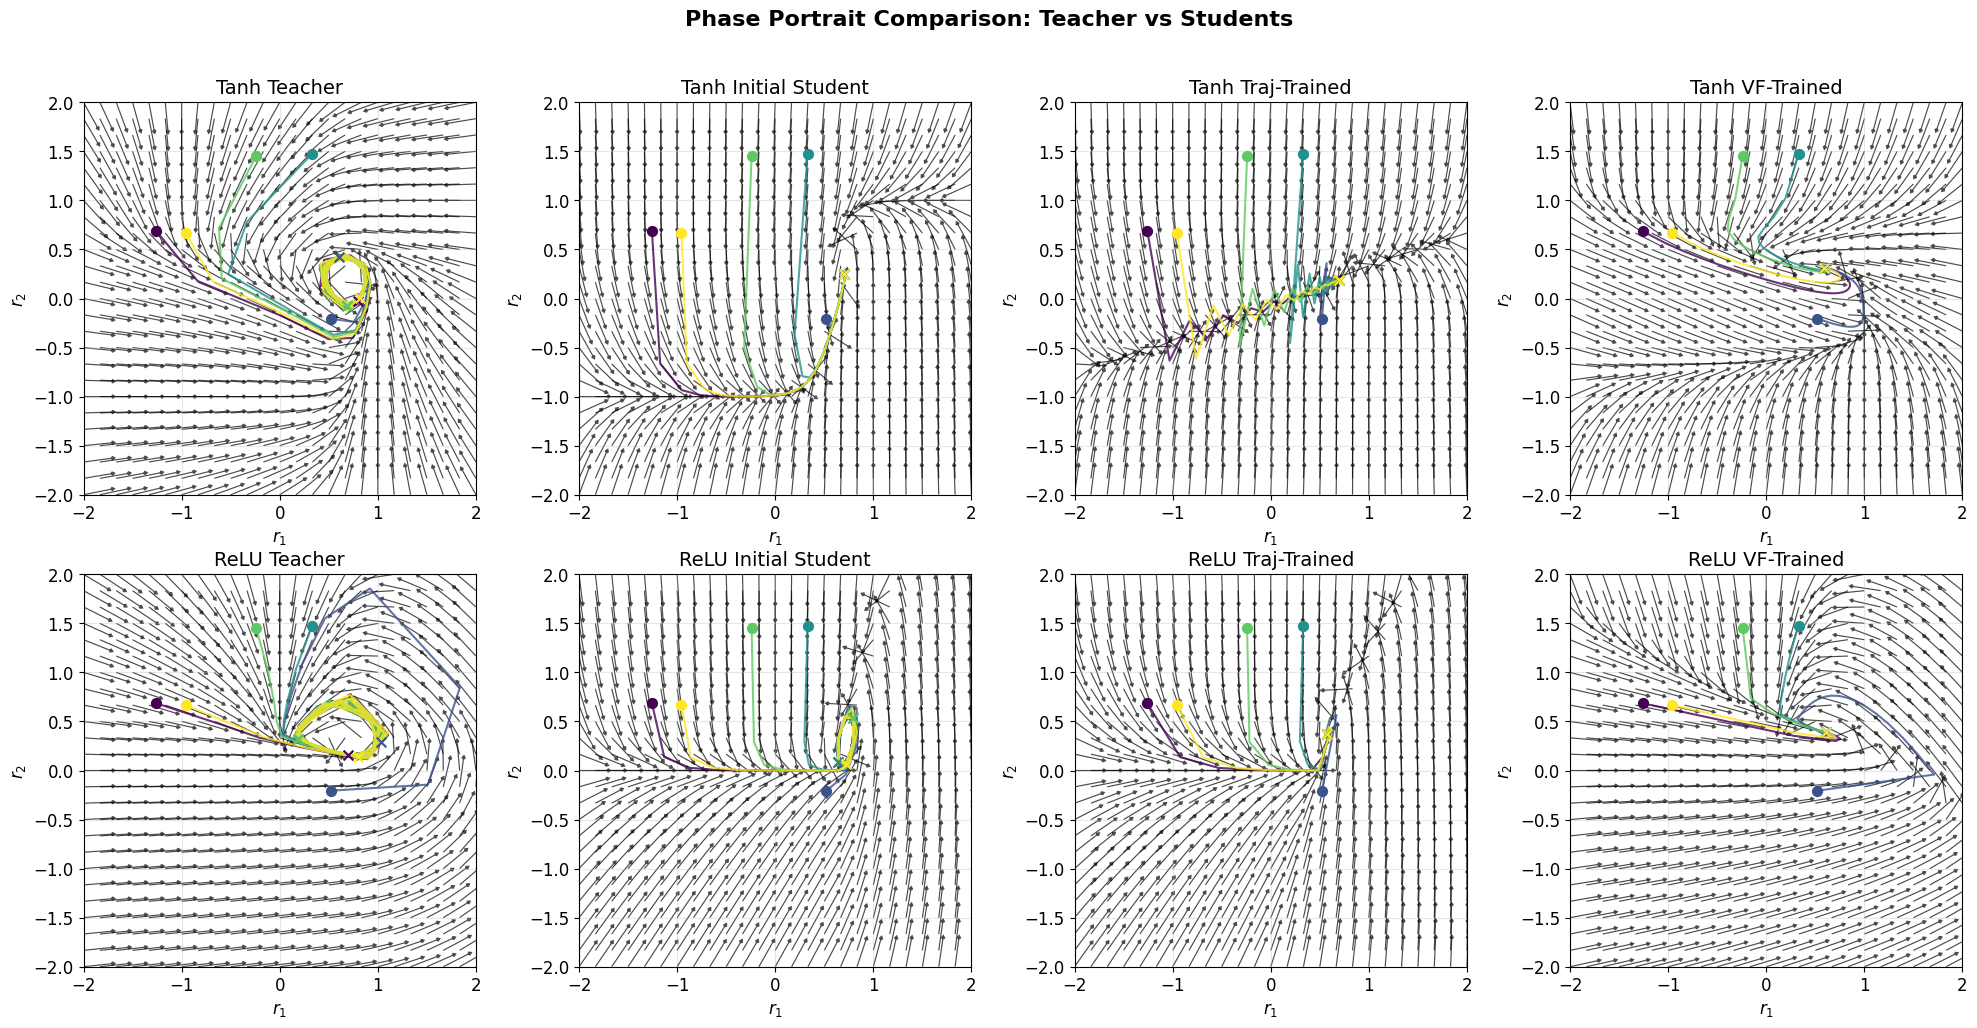

In [72]:
# === PHASE PORTRAIT COMPARISON ===
# 2x4 grid: Rows = [Tanh, ReLU], Cols = [Teacher, Initial, Traj-Trained, VF-Trained]

plot_comparison_grid(results_tanh, results_relu, n_traj=5, T_viz=100, lim=2.0)

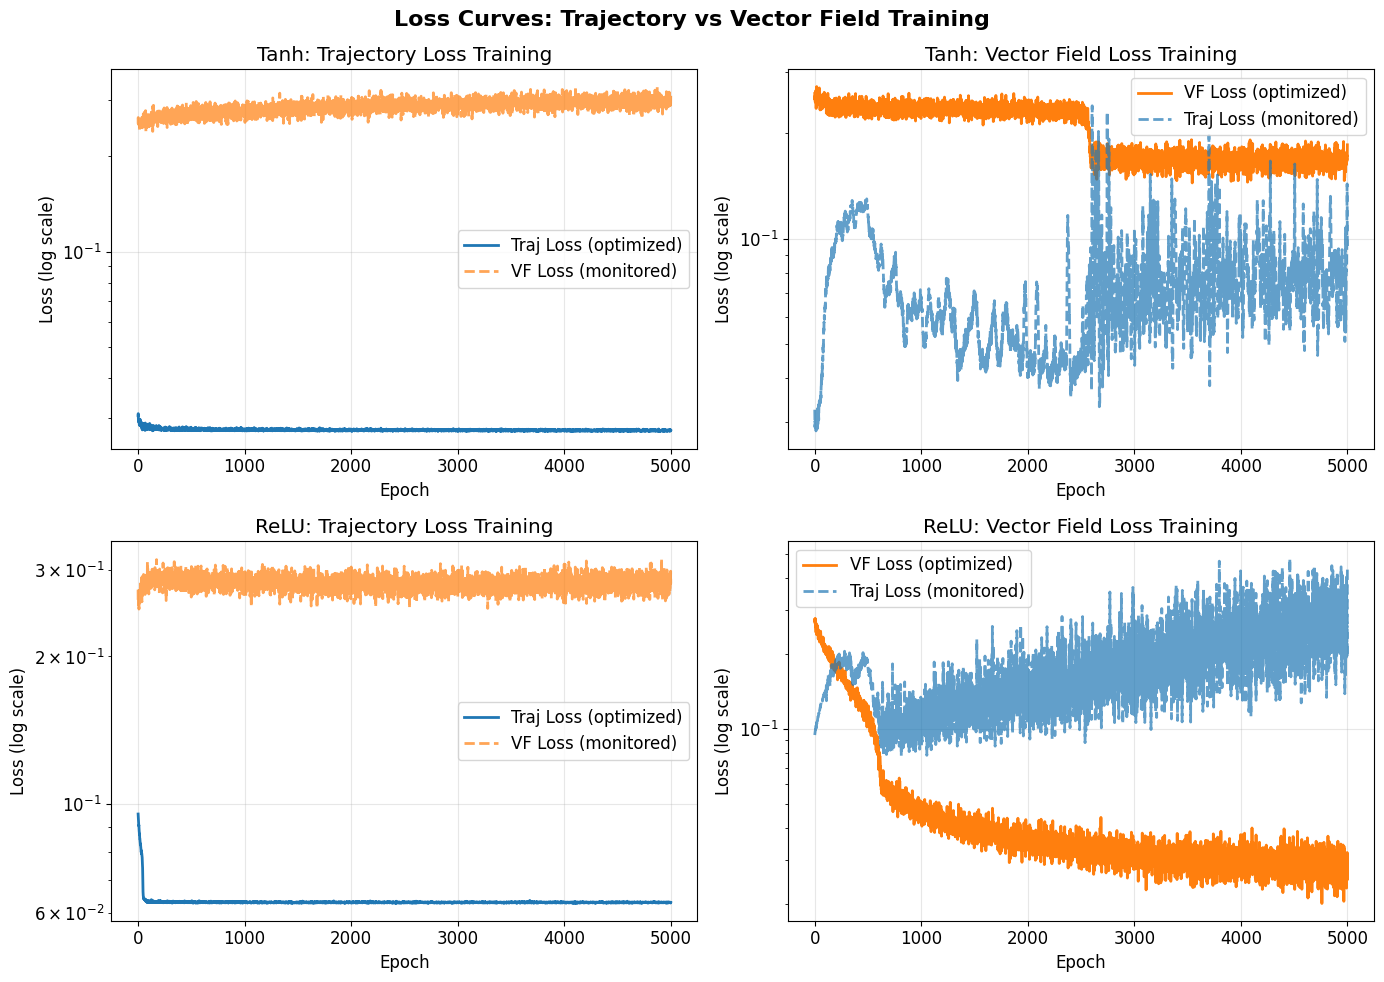


FINAL LOSS SUMMARY
Activation Training           Final Traj Loss      Final VF Loss
----------------------------------------------------------------------
Tanh       Traj Loss                 0.027370           0.310703
           VF Loss                   0.093323           0.185648
ReLU       Traj Loss                 0.062964           0.281570
           VF Loss                   0.438988           0.027720


In [73]:
# === LOSS CURVES ===
# Shows both trajectory loss and VF loss during training for each method

plot_loss_curves(results_tanh, results_relu)

## 6. Summary

In [74]:
# === EXPERIMENT SUMMARY ===
print("=" * 70)
print("EXPERIMENT SUMMARY")
print("=" * 70)

print("\n--- Network Configuration ---")
print(f"Number of neurons: {NUM_NEURONS}")
print(f"Trajectory length T: {T}")
print(f"Training epochs: {N_EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LR}")
print(f"VF normalize mode: {VF_NORMALIZE_MODE}")

print("\n--- Teacher Alphas ---")
print(f"α = {CUSTOM_TEACHER_ALPHAS.numpy()}")

print("\n--- Student Alphas ---")
print(f"α = {CUSTOM_STUDENT_ALPHAS.numpy()}")

print("\n--- Learned Weights Comparison ---")
print("\nTanh Student (Traj-trained) W_rec:")
print(results_tanh["student_traj"].W_rec.weight.data.numpy())
print(f"Bias: {results_tanh['student_traj'].W_rec.bias.data.numpy()}")

print("\nTanh Student (VF-trained) W_rec:")
print(results_tanh["student_vf"].W_rec.weight.data.numpy())
print(f"Bias: {results_tanh['student_vf'].W_rec.bias.data.numpy()}")

print("\nReLU Student (Traj-trained) W_rec:")
print(results_relu["student_traj"].W_rec.weight.data.numpy())
print(f"Bias: {results_relu['student_traj'].W_rec.bias.data.numpy()}")

print("\nReLU Student (VF-trained) W_rec:")
print(results_relu["student_vf"].W_rec.weight.data.numpy())
print(f"Bias: {results_relu['student_vf'].W_rec.bias.data.numpy()}")

print("\n--- Teacher Weights (for reference) ---")
print(f"W_rec:\n{CUSTOM_W.numpy()}")
print(f"Bias: {CUSTOM_B.numpy()}")

EXPERIMENT SUMMARY

--- Network Configuration ---
Number of neurons: 2
Trajectory length T: 80
Training epochs: 5000
Batch size: 128
Learning rate: 0.01
VF normalize mode: angular_mse

--- Teacher Alphas ---
α = [0.5 0.3]

--- Student Alphas ---
α = [0.1 0.8]

--- Learned Weights Comparison ---

Tanh Student (Traj-trained) W_rec:
[[-3.6008086 -7.853061 ]
 [ 0.7856379 -1.2648201]]
Bias: [ 4.815354   -0.11675121]

Tanh Student (VF-trained) W_rec:
[[-2.1298668  -6.554457  ]
 [ 0.06244585  1.059045  ]]
Bias: [ 3.962869   -0.04476119]

ReLU Student (Traj-trained) W_rec:
[[-1.2256898  -2.3691485 ]
 [ 3.4705951  -0.97221714]]
Bias: [ 2.1551201 -1.254252 ]

ReLU Student (VF-trained) W_rec:
[[-10.183922   -18.450432  ]
 [  0.21131733   0.9331651 ]]
Bias: [13.944283   -0.10204615]

--- Teacher Weights (for reference) ---
W_rec:
[[-0.116     -3.5400002]
 [ 3.5400002 -0.116    ]]
Bias: [ 1.83 -2.2 ]
